<a href="https://colab.research.google.com/github/lazybear-0425/EWC_Observation/blob/main/2025-03-24_21_40_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 - Life Lone Learning
 - Elastic Weight Consolidation (EWC)
    - [教學](https://www.kaggle.com/code/hughiephan/elastic-weight-consolidation-on-minst)
    - [Paper](https://arxiv.org/pdf/1612.00796)
    - 公式 $\mathcal{L}(\theta) = \mathcal{L}_B(\theta) + \frac\lambda2\sum^n_{i=1}F_i(\theta_i - \theta^*_{A,i})^2$
        - B是指目前任務，A是指前一個任務
 - [教學2](https://github.com/ContinualAI/colab/blob/master/notebooks/intro_to_continual_learning.ipynb)

In [40]:
import torch
from torch import nn
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, Lambda
import numpy as np
from torchvision.datasets import MNIST as FashionMNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD
from torch.nn.functional import cross_entropy

In [41]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [42]:
batch_size = 256
epochs = 10
task = 2

 - [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html)

In [43]:
def trans_compose(i=0):
    return Compose([
        # lambda x : np.rot90(x, i, axes=[0, 1]).copy(), # 使連續
        # lambda x: np.expand_dims(x, axis=-1),  # 因為ToTensor要PIL or ndarray(H x W x C)，之後轉成Tensor(C x H x W)
        ToTensor(),
        # Lambda(lambda x : x / 255.),
        RandomRotation((90 * i, 90 * i)),
        Normalize(mean=[0.0], std=[1])
    ])

In [44]:
# preprocessing
# train_task_1 = FashionMNIST('data', train=True, transform=trans_compose(0), download=True)
# train_task_2 = FashionMNIST('data', train=True, transform=trans_compose(1), download=True)

test_task_1 = FashionMNIST('data', train=False, transform=trans_compose(0), download=True)
test_task_2 = FashionMNIST('data', train=False, transform=trans_compose(1), download=True)

task_1_loader = DataLoader(test_task_1, batch_size=batch_size)
task_2_loader = DataLoader(test_task_2, batch_size=batch_size)

In [45]:
class Module(nn.Module):
    def __init__(self):
        super(Module, self).__init__()
        # self.classifier = nn.Sequential(
        #     nn.Conv2d(1, 10, kernel_size=5),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        #     nn.Conv2d(10, 20, kernel_size=5),
        #     nn.Dropout2d(),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        # )
        # self.dense = nn.Sequential(
        #     nn.Linear(320, 50),
        #     nn.ReLU(),
        #     nn.Dropout(),
        #     nn.Linear(50, 10)
        # )
        self.net = nn.Sequential(
            # nn.Flatten(),
            # nn.LazyLinear(10),
            nn.Conv2d(1, 10, kernel_size=3, padding=1, stride=2),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Conv2d(10, 5, kernel_size=3, padding=1, stride=2),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(5),
            nn.Flatten(),
            nn.LazyLinear(10)
        )
    def forward(self, X):
        # return self.dense(self.classifier(X).view(-1, 320))
        return self.net(X)

In [46]:
def evaluate(model, dataloader, num_data, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")

    test_acc = 0
    test_loss = 0
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            test_loss += cross_entropy(output, label)
            test_acc += (output.argmax(1) == label).sum()
    print('\033[33m' +
          f'Task {num_task} Acc: {test_acc / num_data: .4f}, Loss: {test_loss / num_data: .4f}' +
          '\033[0m')

In [47]:
def training_Setting(model):
    optimizer = Adam(model.parameters())
    loss = CrossEntropyLoss()
    return optimizer, loss

 - Fisher Matrix
     - 儲存權重對模型重要性
     - 計算方法
         - [LINK](https://github.com/db434/EWC)
             - 這個版本是**取樣** $\rightarrow$ 計算梯度
         - 這邊的範例程式碼是直接**整個資料**來計算梯度
         - 公式
             - $F_j = \frac1m \sum^m_{i=1}(\frac{\partial \log (P(x_i|\theta_j))}{\partial \theta_j})^2$

In [ ]:
# EWC
optim_para = {}
fisher_matrix = {}
ewc_lambda = 10

def record_parameter(model, train_data, optimizer, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    model.train()
    optimizer.zero_grad()

    fisher_matrix[num_task] = {}
    optim_para[num_task] = {}

    # Initialize Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] = torch.zeros_like(param.data)

    # Calculate Fisher Matrix
    for data in train_loader:
        img, label = data
        img, label = img.to(device), label.to(device).long()
        output = model(img)
        output_loss = cross_entropy(output, label)
        output_loss.backward()

        for name, param in model.named_parameters():
            if param.grad is not None:
                fisher_matrix[num_task][name] += param.grad.data.clone().pow(2)

    # Average Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] /= len(train_loader)

    # Save optimal parameters
    for name, param in model.named_parameters():
        optim_para[num_task][name] = param.data.clone()

In [49]:
def training(model, test_loader : list, test_num : list, epochs = 10,  num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    print(f'Task {num_task} Start!')

    train_data = FashionMNIST('data', train=True, transform=trans_compose(num_task), download=True)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    # plt.imshow(train_data[0][0].reshape(28, 28), cmap='gray')
    # plt.title('Task' + str(num_task))
    # plt.show()

    # optimizer, loss = training_Setting(model)
    optimizer = Adam(model.parameters()) #SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    for i in range(epochs):
        model.train()
        train_acc = 0
        train_loss = 0
        for data in train_loader:
            optimizer.zero_grad()

            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            output_loss = cross_entropy(output, label)
            # Record
            train_acc += (output.argmax(1) == label).sum()
            # BP
            ewc_loss = 0
            for t in range(num_task):
                for name, param in model.named_parameters():
                    if t in optim_para:
                        fisher = fisher_matrix[t][name]
                        optim = optim_para[t][name]
                        if fisher.requires_grad == True or optim.requires_grad == True:
                            raise NotImplementedError('Frozen it!')
                        # output_loss += ewc_lambda * (fisher * (optim - param).pow(2)).sum() # .detach()
                        ewc_loss += (fisher * (optim - param).pow(2)).sum() * ewc_lambda
            # if tmp != 0: print(tmp)
            output_loss += ewc_loss
            train_loss += output_loss.detach()
            output_loss.backward()
            optimizer.step()
        print(f'Epoch\t{i + 1}\tAcc: {train_acc / len(train_data): .4f}, Loss: {train_loss / len(train_data): .4f}')
    record_parameter(model, train_data, optimizer, num_task=num_task)
    # Evaluate Task 0 & 1
    task_id = 0
    for num_data, loader in zip(test_num, test_loader):
        evaluate(model, loader, num_data, task_id)
        task_id = task_id + 1
    print() # End of Training

 - nn.Module
    - named_pa​​rameters()
         - 給出網絡層的名字和參數的迭代器
    - parameters()
         - 參數的迭代器
    - [Reference](https://blog.csdn.net/qq_36530992/article/details/102729585)

In [50]:
from torchsummary import summary
model = Module().to(device)
summary(model, (1, 28, 28))

for i in range(task):
    training(model, [task_1_loader, task_2_loader], [len(test_task_1), len(test_task_2)], num_task=i, epochs=epochs)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 14, 14]             100
         MaxPool2d-2             [-1, 10, 7, 7]               0
              ReLU-3             [-1, 10, 7, 7]               0
       BatchNorm2d-4             [-1, 10, 7, 7]              20
            Conv2d-5              [-1, 5, 4, 4]             455
         MaxPool2d-6              [-1, 5, 2, 2]               0
              ReLU-7              [-1, 5, 2, 2]               0
       BatchNorm2d-8              [-1, 5, 2, 2]              10
           Flatten-9                   [-1, 20]               0
           Linear-10                   [-1, 10]             210
Total params: 795
Trainable params: 795
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.00
Estimated Total Siz

 - Task 0

Accuracy 0.3997
Classification Report
              precision    recall  f1-score   support

    0 - zero       0.60      0.48      0.54       980
     1 - one       0.61      0.62      0.62      1135
     2 - two       0.64      0.59      0.62      1032
   3 - three       0.30      0.37      0.33      1010
    4 - four       0.24      0.82      0.37       982
    5 - five       0.54      0.14      0.22       892
     6 - six       0.90      0.37      0.52       958
   7 - seven       0.31      0.46      0.37      1028
   8 - eight       0.52      0.05      0.09       974
    9 - nine       0.17      0.04      0.07      1009

    accuracy                           0.40     10000
   macro avg       0.48      0.39      0.37     10000
weighted avg       0.48      0.40      0.38     10000



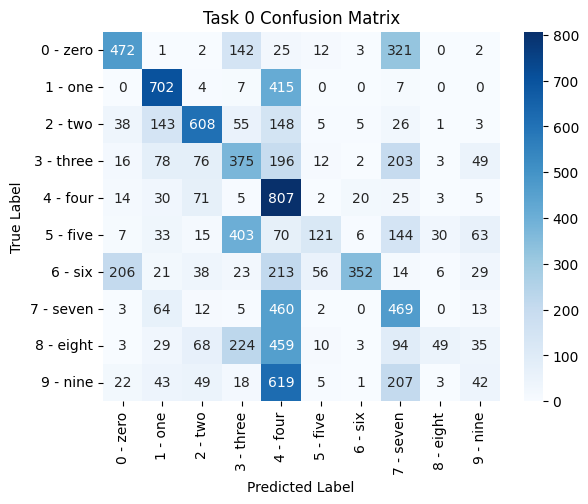

In [51]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_1_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_1.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_1.classes, yticklabels=test_task_1.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 0 Confusion Matrix")
plt.show()

 - Task 1

Accuracy 0.5879
Classification Report
              precision    recall  f1-score   support

    0 - zero       0.74      0.77      0.76       980
     1 - one       0.76      0.95      0.84      1135
     2 - two       0.69      0.52      0.59      1032
   3 - three       0.52      0.50      0.51      1010
    4 - four       0.49      0.42      0.45       982
    5 - five       0.32      0.18      0.23       892
     6 - six       0.51      0.64      0.57       958
   7 - seven       0.59      0.66      0.62      1028
   8 - eight       0.53      0.58      0.56       974
    9 - nine       0.53      0.57      0.55      1009

    accuracy                           0.59     10000
   macro avg       0.57      0.58      0.57     10000
weighted avg       0.58      0.59      0.58     10000



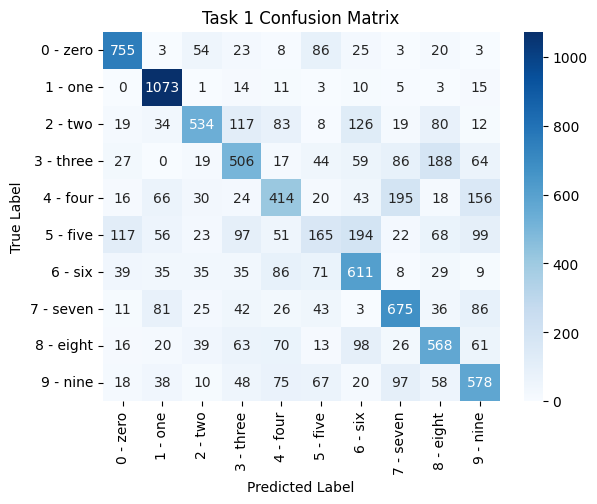

In [52]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_2_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_2.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_2.classes, yticklabels=test_task_2.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 1 Confusion Matrix")
plt.show()

net.0.weight
torch.Size([10, 1, 3, 3])
Max fisher is 0.00000 and it's parameter diff is 0.00000
Min Parameter diff is 0.00000 and it's fisher is 0.00000
fisher > parameter diff: 0
fisher <= parameter diff: 9


<Figure size 640x480 with 0 Axes>

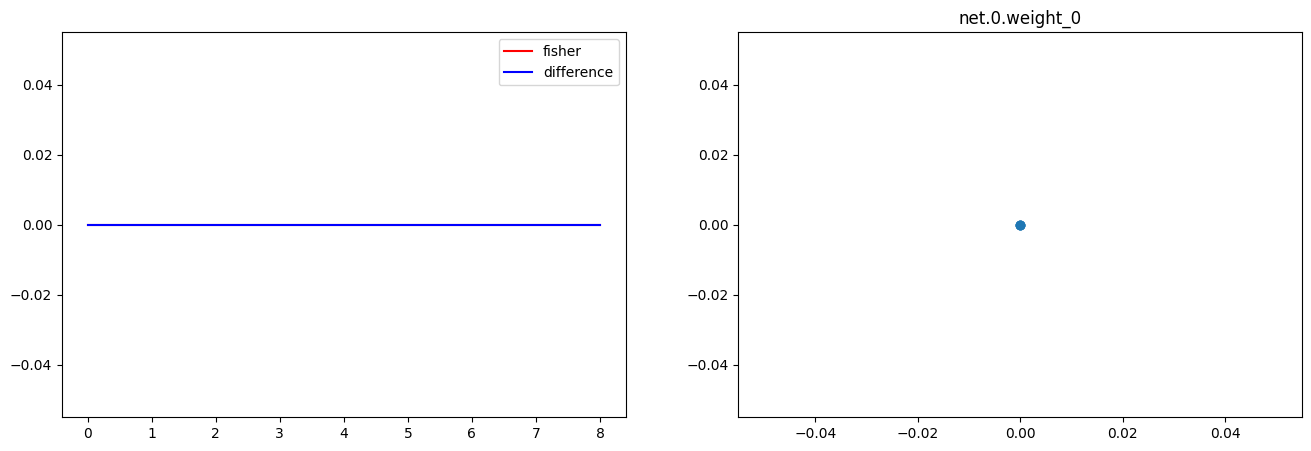

Max fisher is 0.36714 and it's parameter diff is 0.00122
Min Parameter diff is 0.26711 and it's fisher is 0.00508
fisher > parameter diff: 5
fisher <= parameter diff: 4


<Figure size 640x480 with 0 Axes>

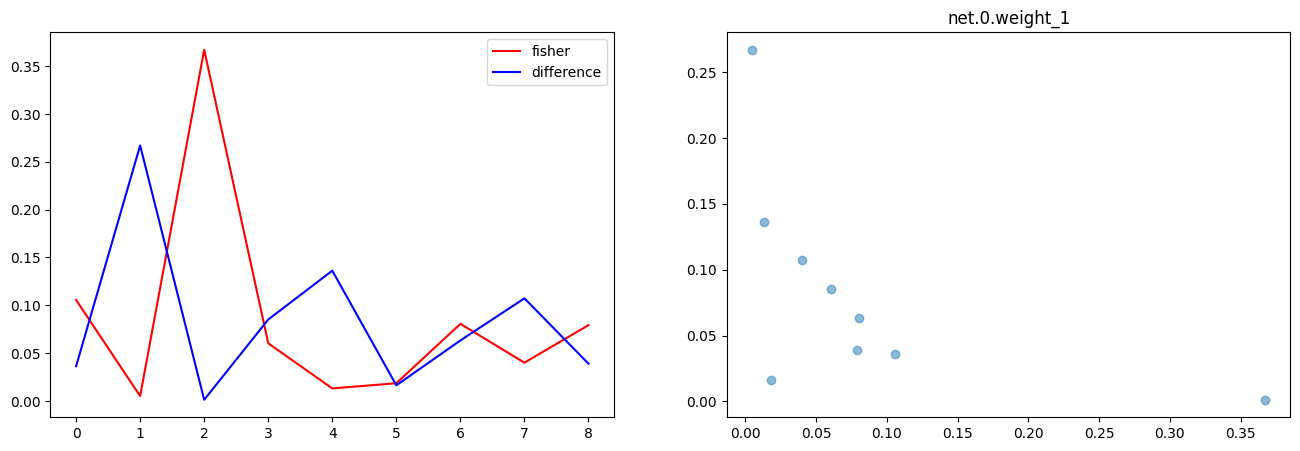

Max fisher is 0.00111 and it's parameter diff is 0.00995
Min Parameter diff is 0.02983 and it's fisher is 0.00001
fisher > parameter diff: 2
fisher <= parameter diff: 7


<Figure size 640x480 with 0 Axes>

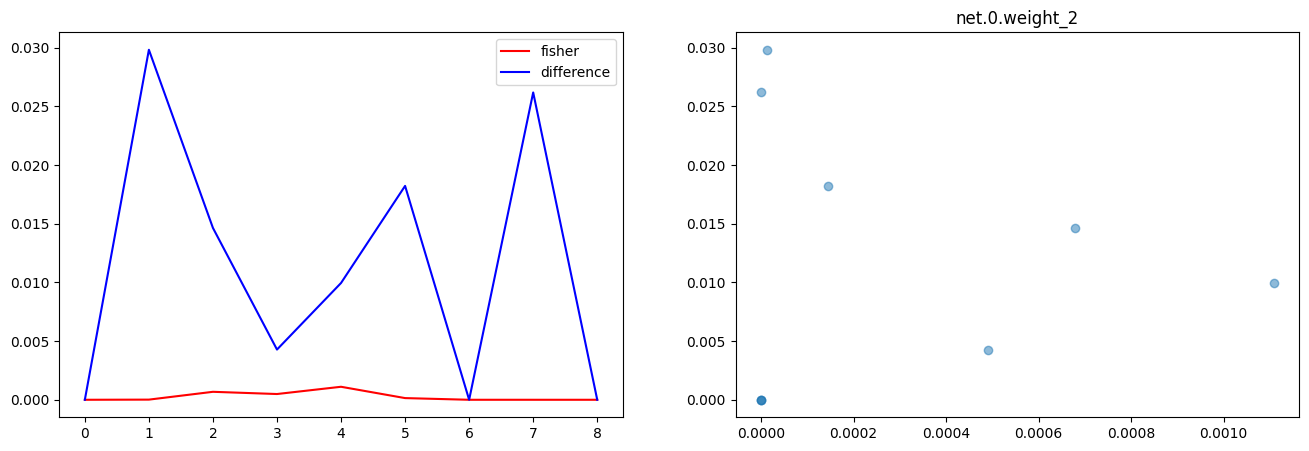

Max fisher is 10.03610 and it's parameter diff is 0.00088
Min Parameter diff is 0.05997 and it's fisher is 0.05700
fisher > parameter diff: 8
fisher <= parameter diff: 1


<Figure size 640x480 with 0 Axes>

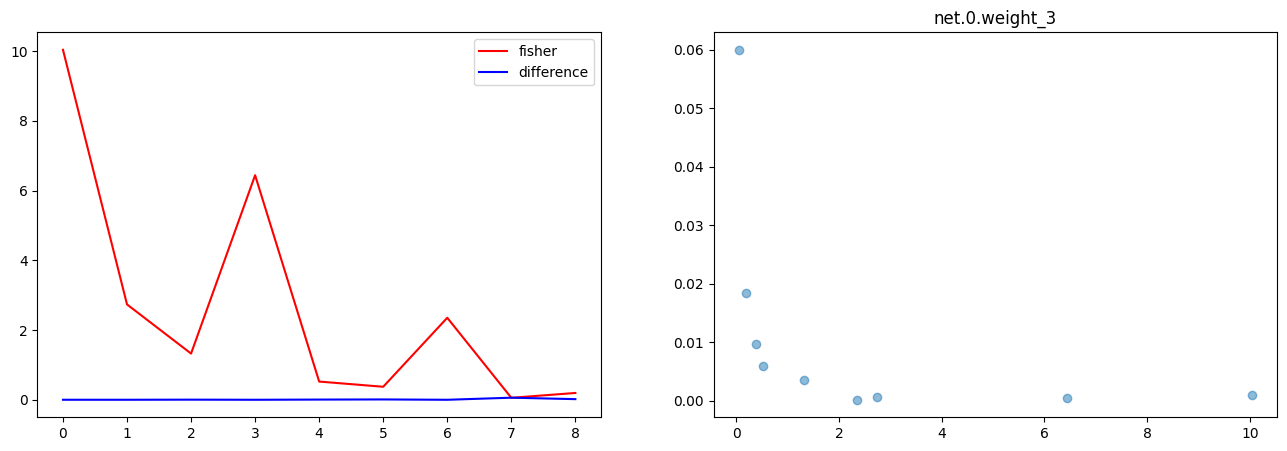

Max fisher is 1.56322 and it's parameter diff is 0.00239
Min Parameter diff is 0.02420 and it's fisher is 0.28592
fisher > parameter diff: 9
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

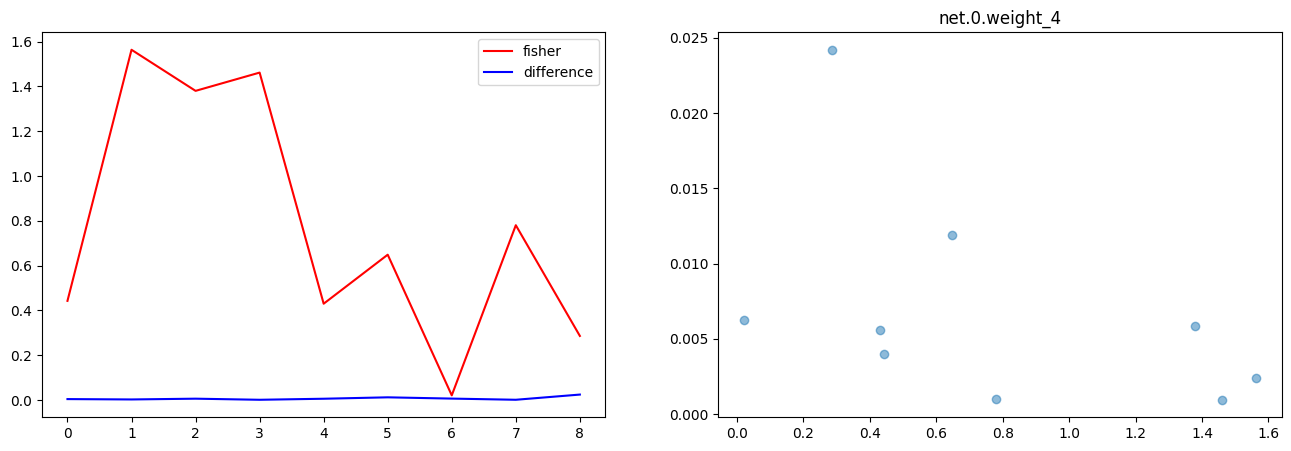

Max fisher is 1.34888 and it's parameter diff is 0.00240
Min Parameter diff is 0.25044 and it's fisher is 0.00563
fisher > parameter diff: 8
fisher <= parameter diff: 1


<Figure size 640x480 with 0 Axes>

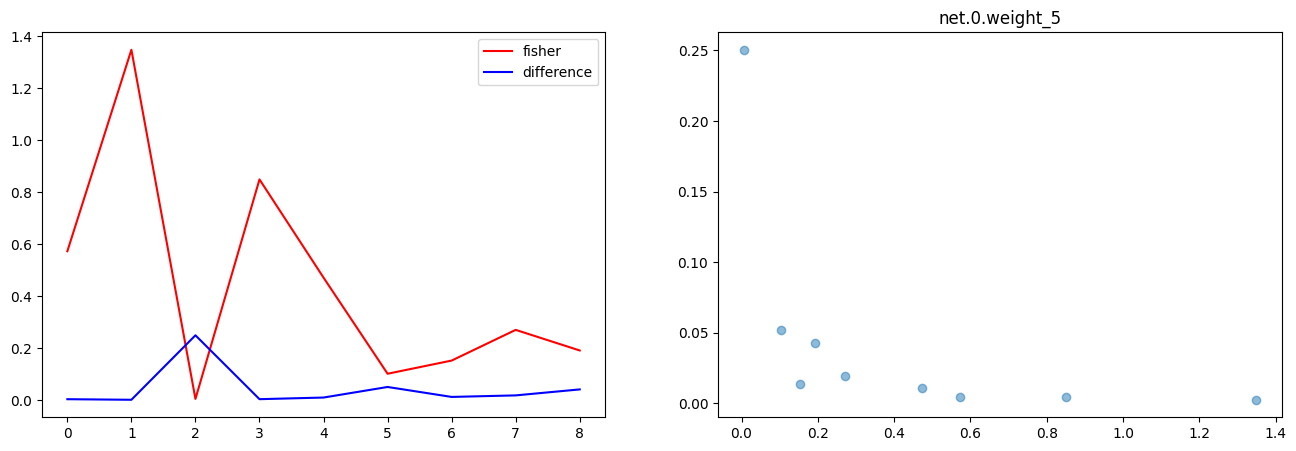

Max fisher is 0.00000 and it's parameter diff is 0.00000
Min Parameter diff is 0.00000 and it's fisher is 0.00000
fisher > parameter diff: 0
fisher <= parameter diff: 9


<Figure size 640x480 with 0 Axes>

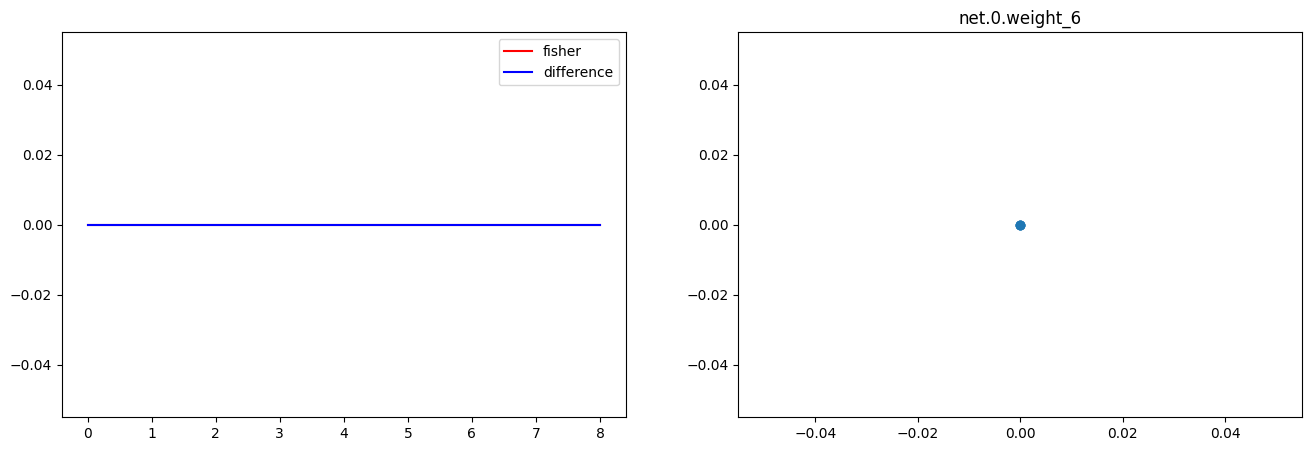

Max fisher is 0.26586 and it's parameter diff is 0.00078
Min Parameter diff is 0.05361 and it's fisher is 0.00000
fisher > parameter diff: 7
fisher <= parameter diff: 2


<Figure size 640x480 with 0 Axes>

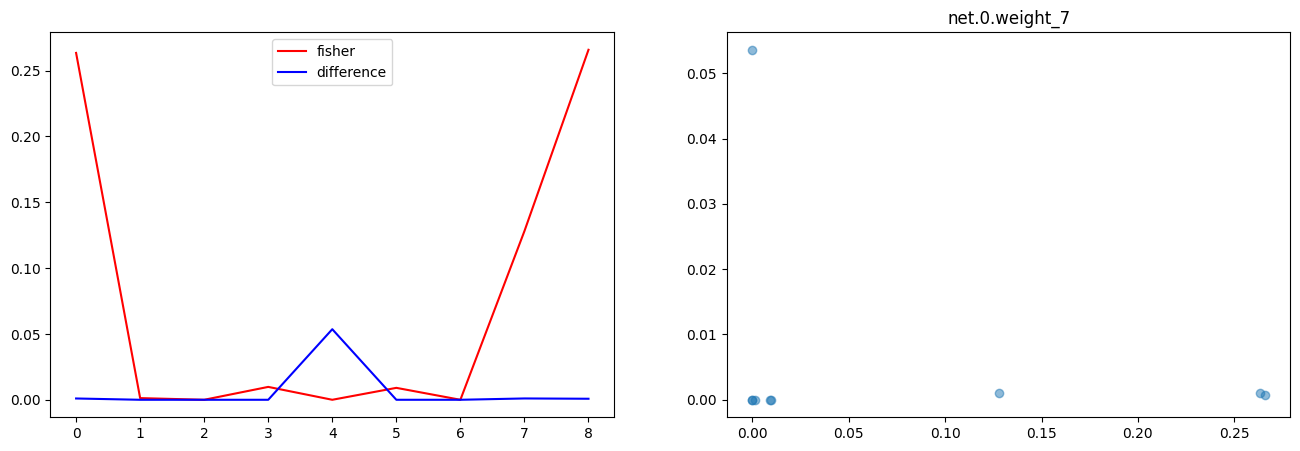

Max fisher is 0.44221 and it's parameter diff is 0.00229
Min Parameter diff is 0.37881 and it's fisher is 0.00421
fisher > parameter diff: 6
fisher <= parameter diff: 3


<Figure size 640x480 with 0 Axes>

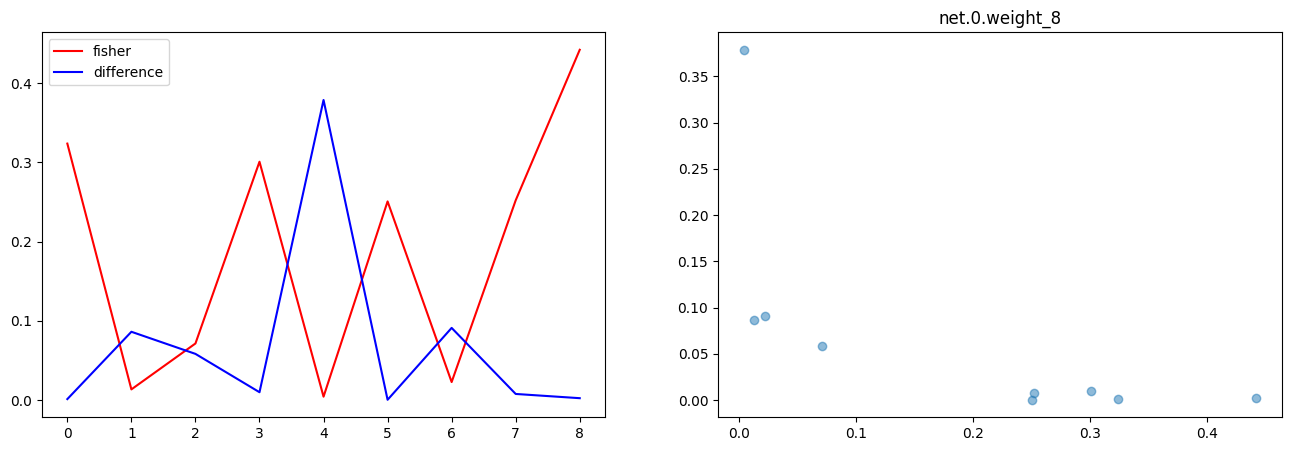

Max fisher is 3.88114 and it's parameter diff is 0.00051
Min Parameter diff is 0.00277 and it's fisher is 1.31746
fisher > parameter diff: 9
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

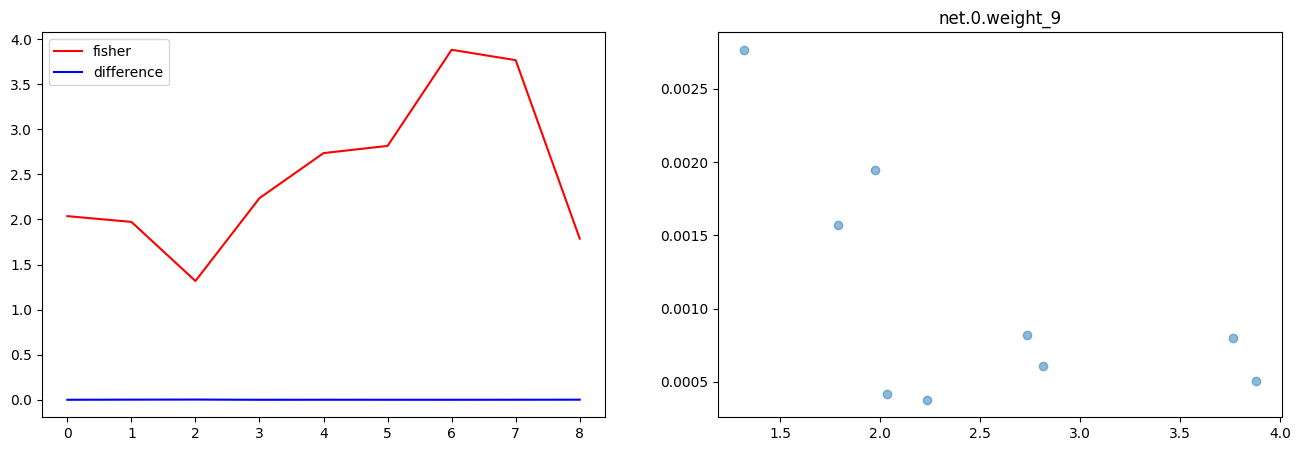


net.0.bias
torch.Size([10])
Max fisher is 6.56948 and it's parameter diff is 0.00023
Min Parameter diff is 0.10153 and it's fisher is 0.00000
fisher > parameter diff: 4
fisher <= parameter diff: 6


<Figure size 640x480 with 0 Axes>

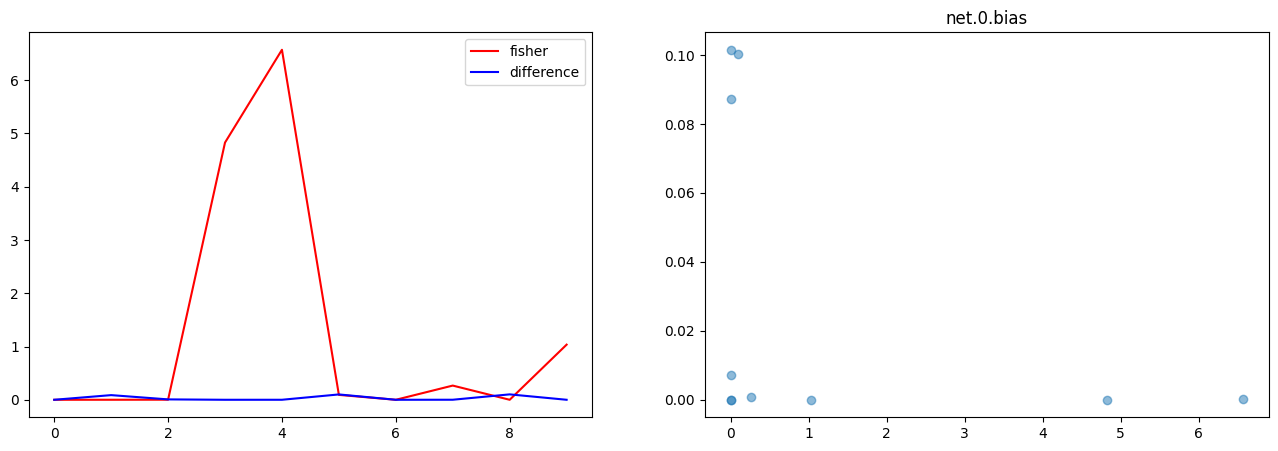


net.3.weight
torch.Size([10])
Max fisher is 0.74459 and it's parameter diff is 0.00060
Min Parameter diff is 0.11215 and it's fisher is 0.04721
fisher > parameter diff: 5
fisher <= parameter diff: 5


<Figure size 640x480 with 0 Axes>

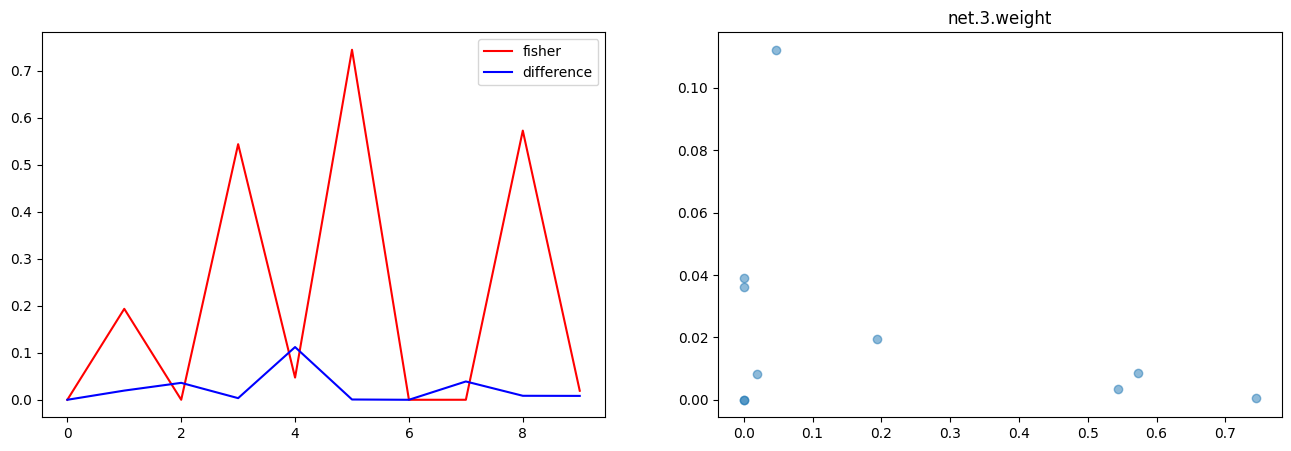


net.3.bias
torch.Size([10])
Max fisher is 1.52645 and it's parameter diff is 0.00004
Min Parameter diff is 0.19348 and it's fisher is 0.01327
fisher > parameter diff: 7
fisher <= parameter diff: 3


<Figure size 640x480 with 0 Axes>

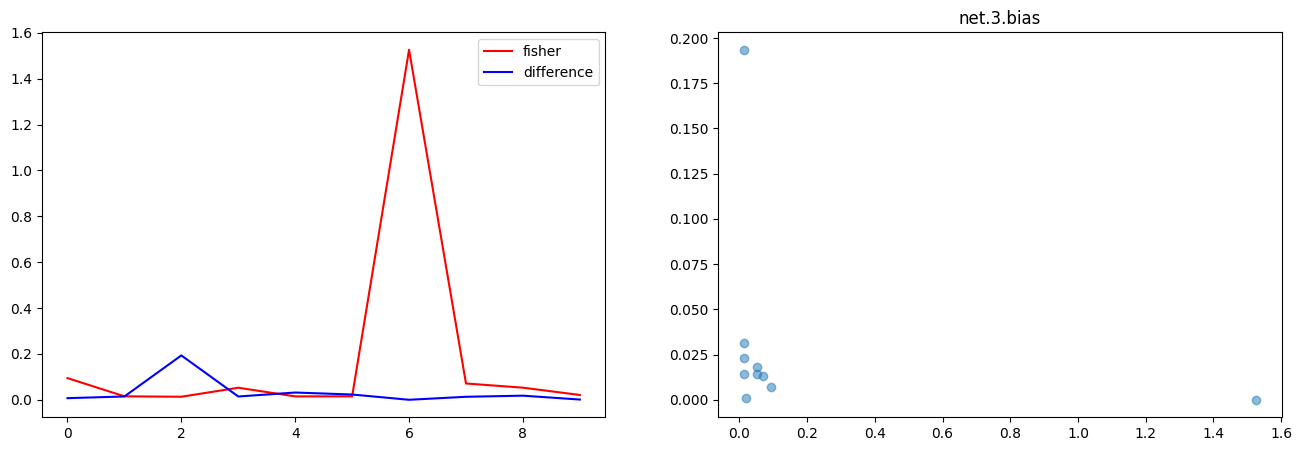


net.4.weight
torch.Size([5, 10, 3, 3])
Max fisher is 10.35134 and it's parameter diff is 0.00083
Min Parameter diff is 0.34404 and it's fisher is 0.00000
fisher > parameter diff: 59
fisher <= parameter diff: 31


<Figure size 640x480 with 0 Axes>

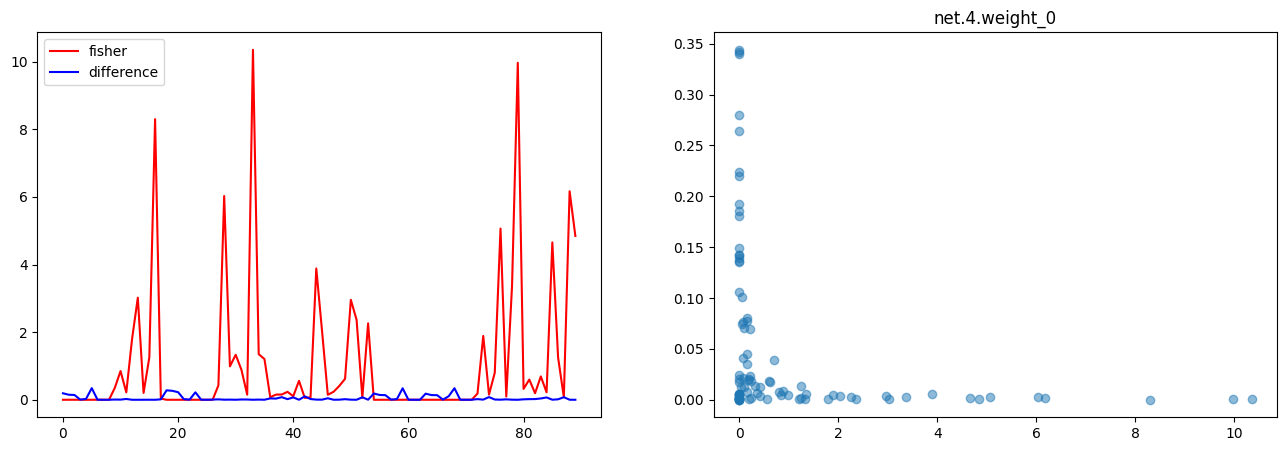

Max fisher is 12.43790 and it's parameter diff is 0.00077
Min Parameter diff is 0.35164 and it's fisher is 0.00208
fisher > parameter diff: 53
fisher <= parameter diff: 37


<Figure size 640x480 with 0 Axes>

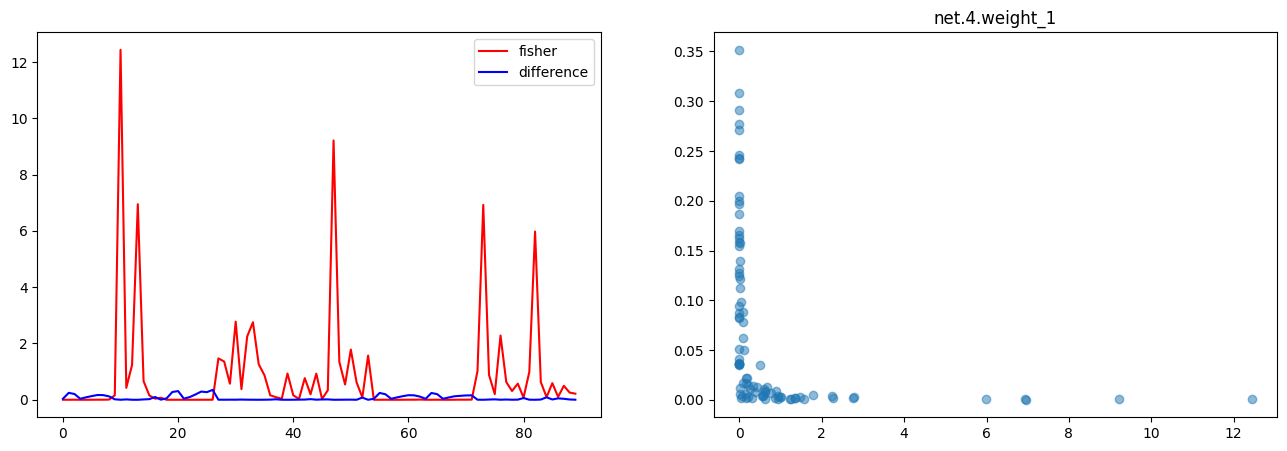

Max fisher is 25.11028 and it's parameter diff is 0.00075
Min Parameter diff is 0.30341 and it's fisher is 0.00054
fisher > parameter diff: 64
fisher <= parameter diff: 26


<Figure size 640x480 with 0 Axes>

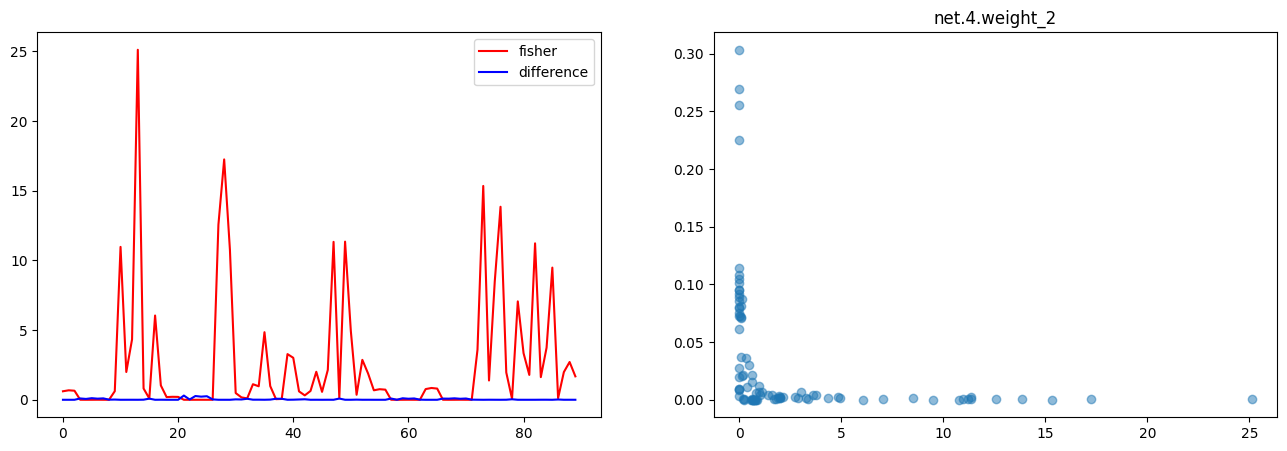

Max fisher is 5.82308 and it's parameter diff is 0.00091
Min Parameter diff is 0.57108 and it's fisher is 0.00008
fisher > parameter diff: 64
fisher <= parameter diff: 26


<Figure size 640x480 with 0 Axes>

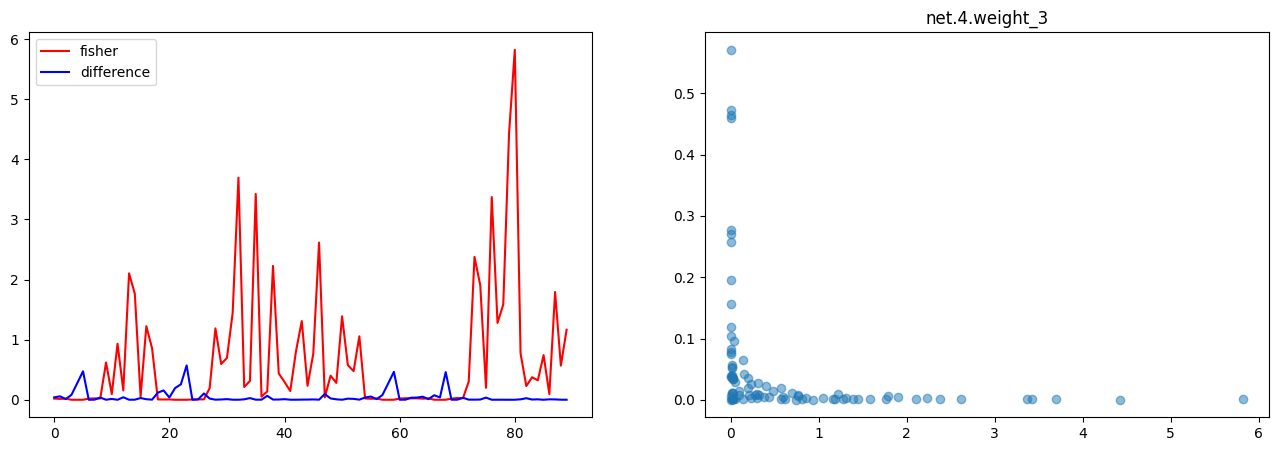

Max fisher is 19.21079 and it's parameter diff is 0.00075
Min Parameter diff is 0.22421 and it's fisher is 0.01536
fisher > parameter diff: 74
fisher <= parameter diff: 16


<Figure size 640x480 with 0 Axes>

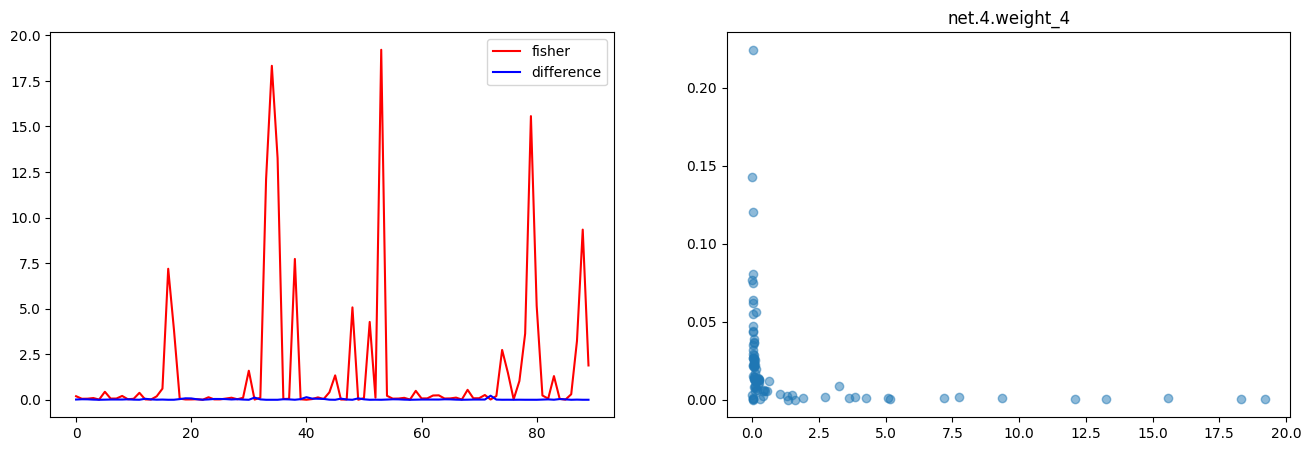


net.4.bias
torch.Size([5])
Max fisher is 0.03544 and it's parameter diff is 0.00041
Min Parameter diff is 0.24165 and it's fisher is 0.00000
fisher > parameter diff: 1
fisher <= parameter diff: 4


<Figure size 640x480 with 0 Axes>

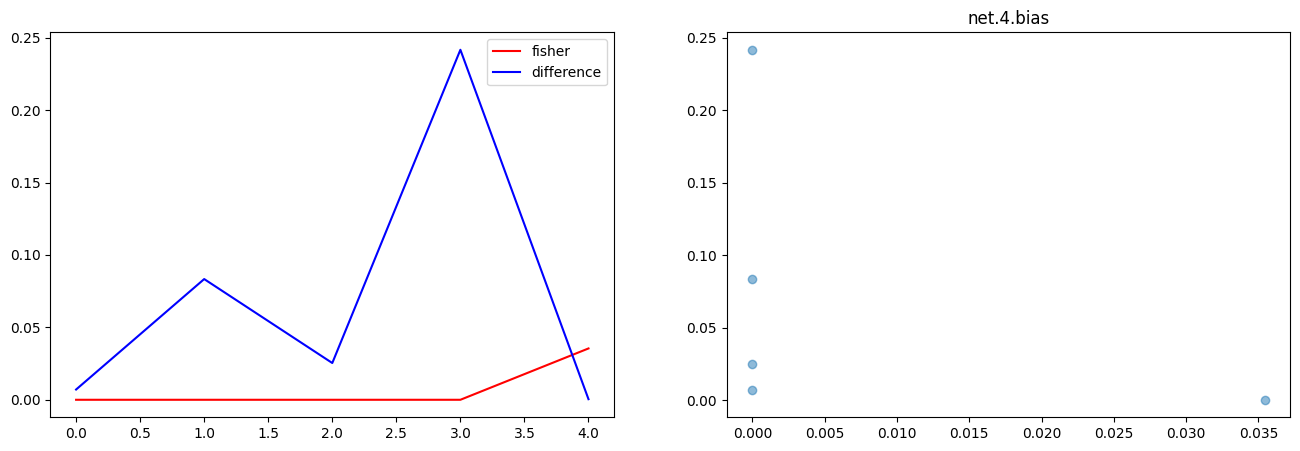


net.7.weight
torch.Size([5])
Max fisher is 0.69320 and it's parameter diff is 0.00114
Min Parameter diff is 0.01427 and it's fisher is 0.12676
fisher > parameter diff: 5
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

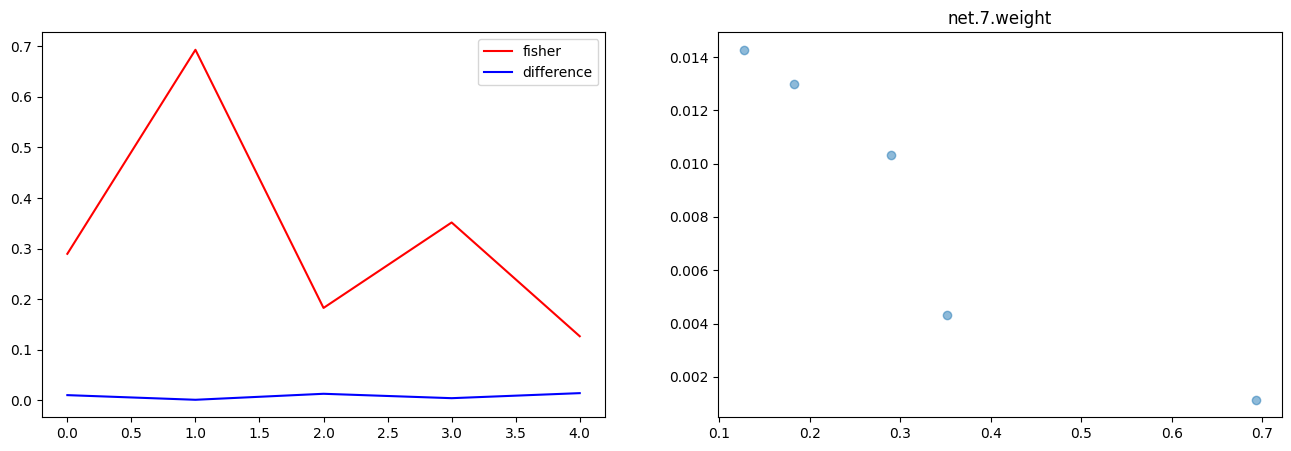


net.7.bias
torch.Size([5])
Max fisher is 0.93405 and it's parameter diff is 0.00132
Min Parameter diff is 0.00715 and it's fisher is 0.03670
fisher > parameter diff: 5
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

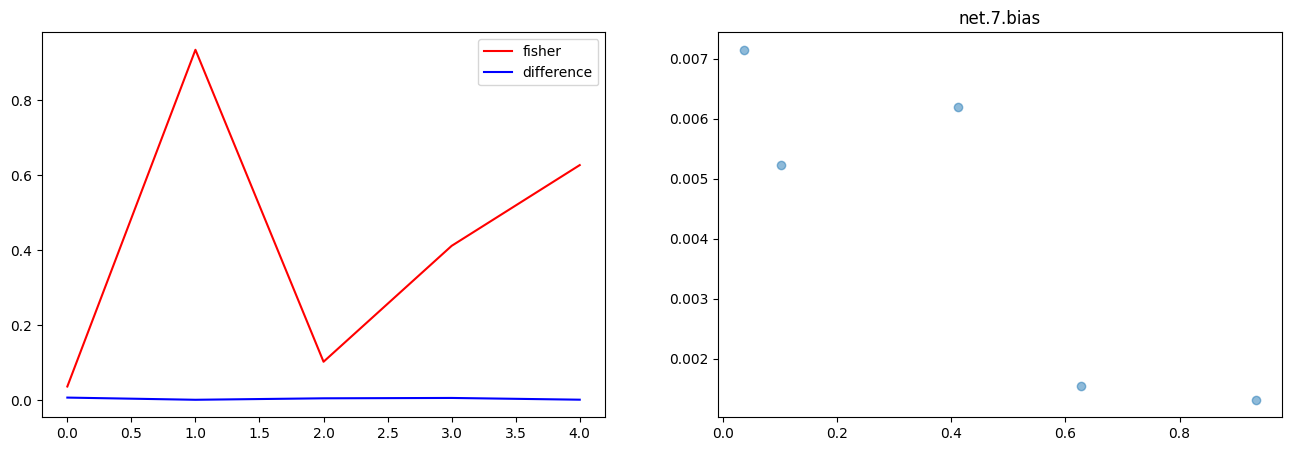


net.9.weight
torch.Size([10, 20])
Max fisher is 0.23150 and it's parameter diff is 0.00571
Min Parameter diff is 0.46171 and it's fisher is 0.00125
fisher > parameter diff: 9
fisher <= parameter diff: 11


<Figure size 640x480 with 0 Axes>

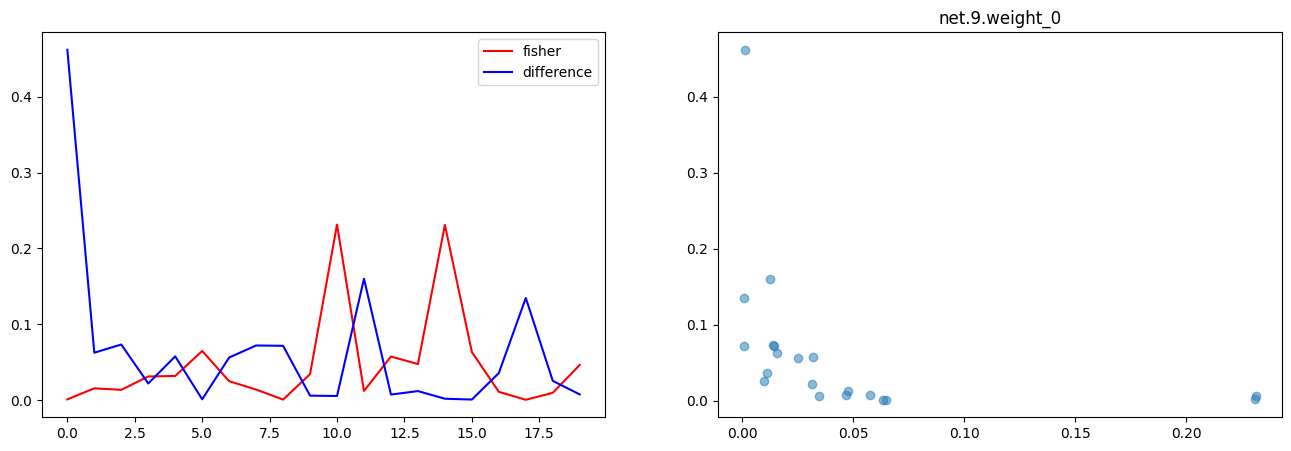

Max fisher is 0.11699 and it's parameter diff is 0.00050
Min Parameter diff is 0.55835 and it's fisher is 0.00010
fisher > parameter diff: 13
fisher <= parameter diff: 7


<Figure size 640x480 with 0 Axes>

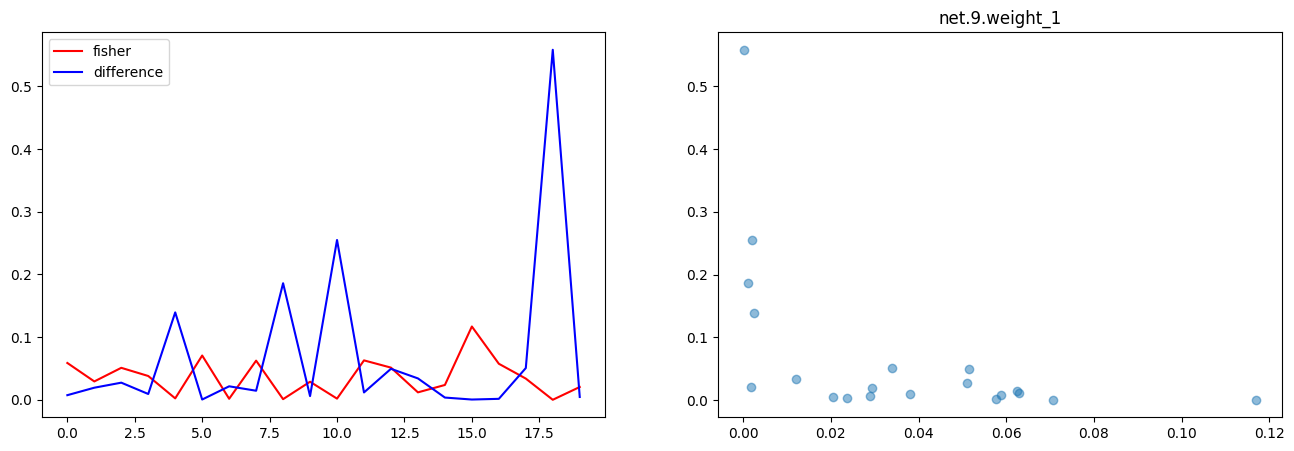

Max fisher is 0.17815 and it's parameter diff is 0.00198
Min Parameter diff is 0.28725 and it's fisher is 0.01038
fisher > parameter diff: 8
fisher <= parameter diff: 12


<Figure size 640x480 with 0 Axes>

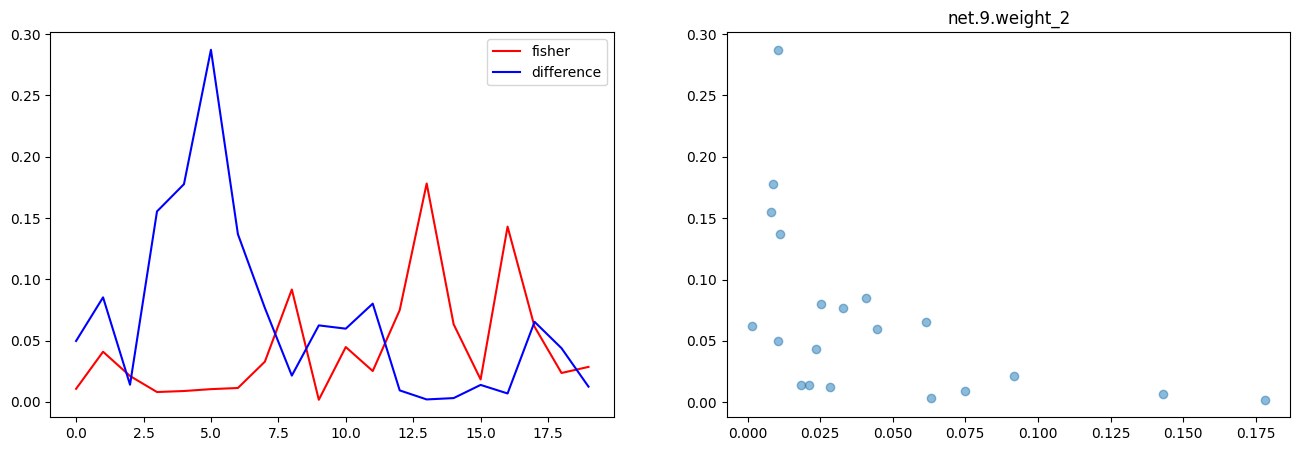

Max fisher is 0.20092 and it's parameter diff is 0.00859
Min Parameter diff is 0.54161 and it's fisher is 0.00309
fisher > parameter diff: 5
fisher <= parameter diff: 15


<Figure size 640x480 with 0 Axes>

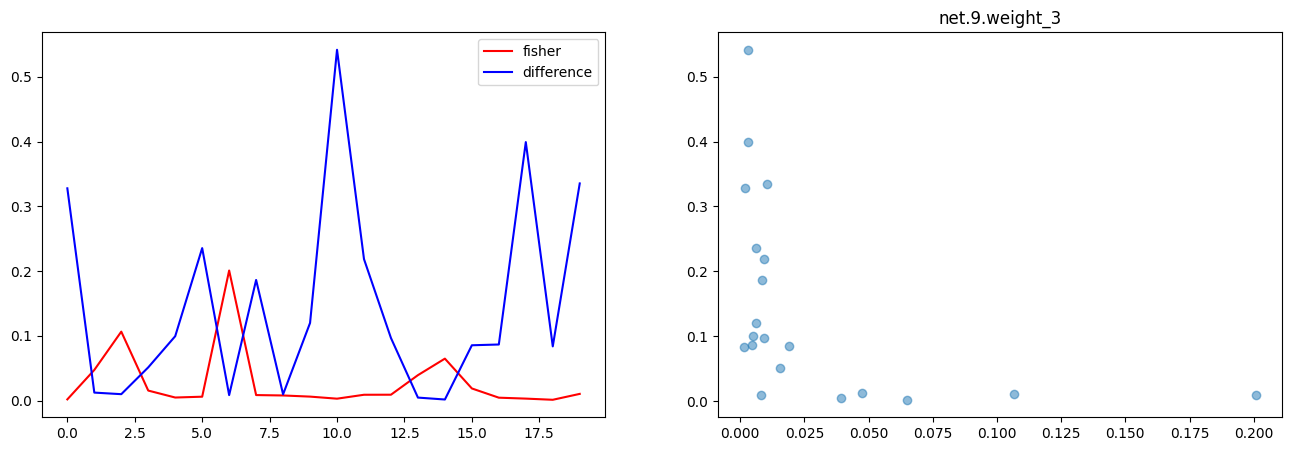

Max fisher is 0.63814 and it's parameter diff is 0.00203
Min Parameter diff is 0.63633 and it's fisher is 0.00379
fisher > parameter diff: 12
fisher <= parameter diff: 8


<Figure size 640x480 with 0 Axes>

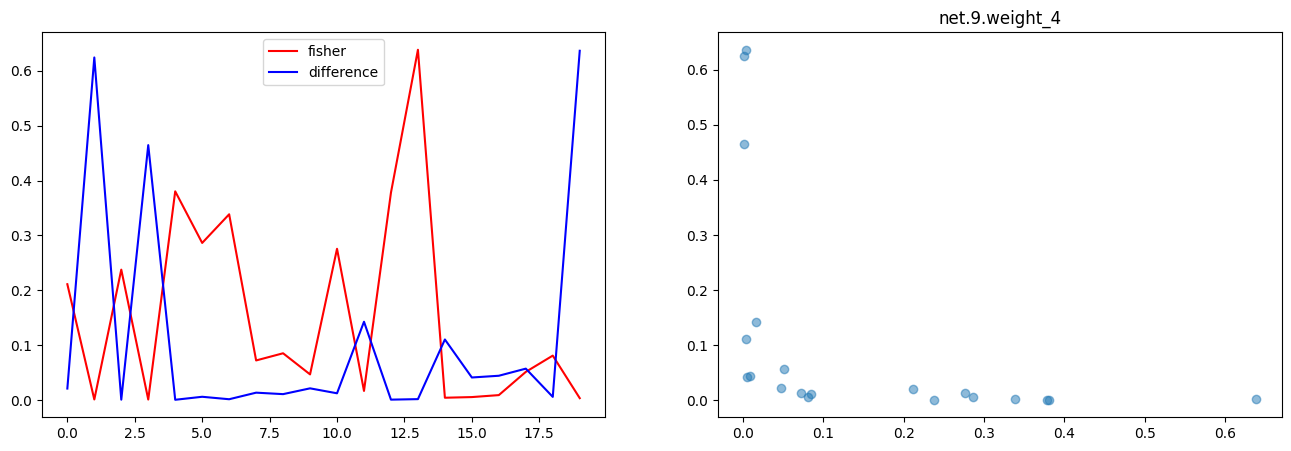

Max fisher is 0.21519 and it's parameter diff is 0.00628
Min Parameter diff is 0.23113 and it's fisher is 0.00988
fisher > parameter diff: 12
fisher <= parameter diff: 8


<Figure size 640x480 with 0 Axes>

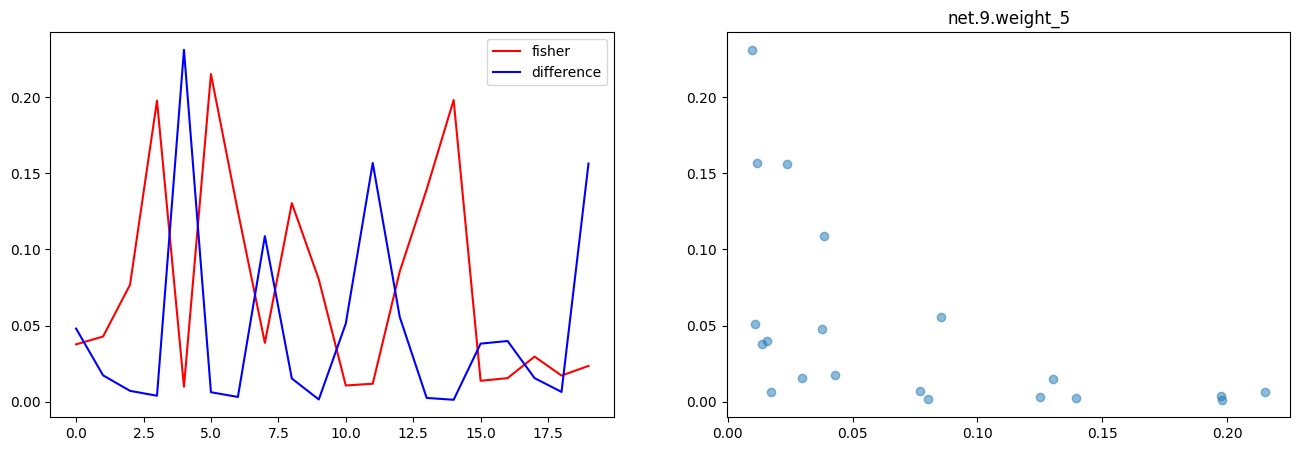

Max fisher is 0.20259 and it's parameter diff is 0.00499
Min Parameter diff is 0.58548 and it's fisher is 0.00148
fisher > parameter diff: 7
fisher <= parameter diff: 13


<Figure size 640x480 with 0 Axes>

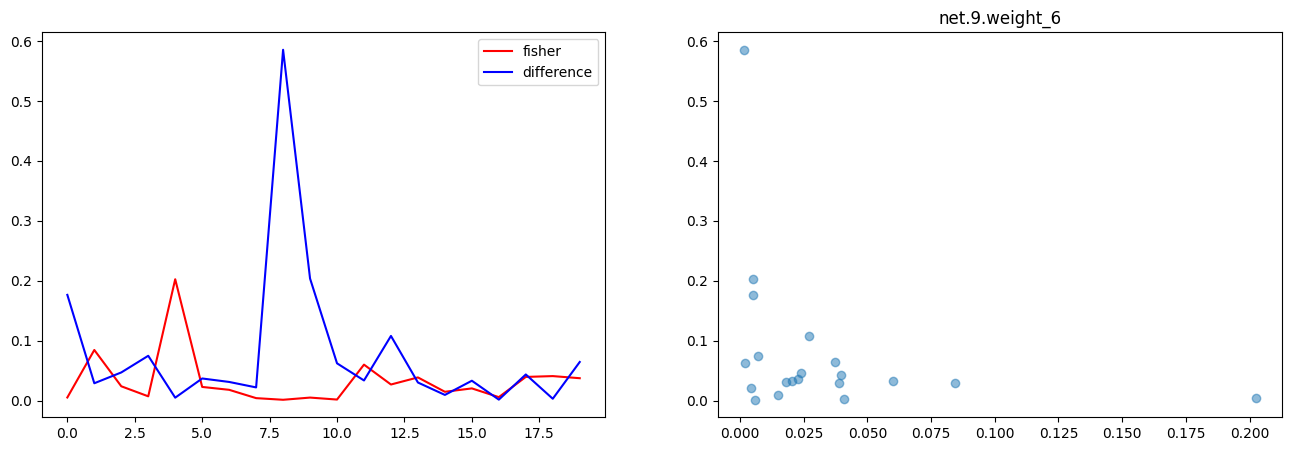

Max fisher is 0.45694 and it's parameter diff is 0.00029
Min Parameter diff is 0.90611 and it's fisher is 0.00256
fisher > parameter diff: 10
fisher <= parameter diff: 10


<Figure size 640x480 with 0 Axes>

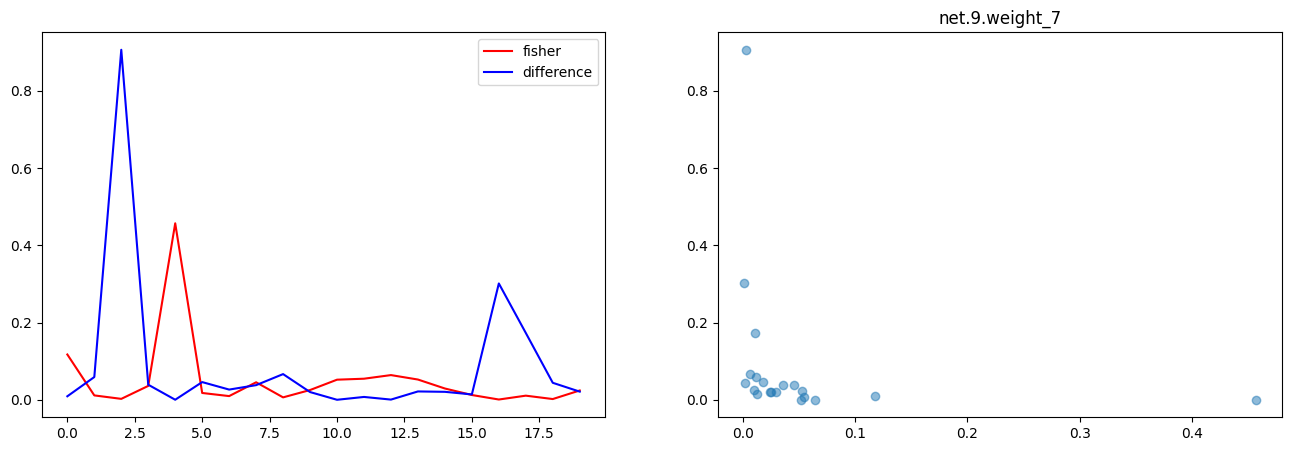

Max fisher is 0.61825 and it's parameter diff is 0.00012
Min Parameter diff is 0.30613 and it's fisher is 0.00289
fisher > parameter diff: 15
fisher <= parameter diff: 5


<Figure size 640x480 with 0 Axes>

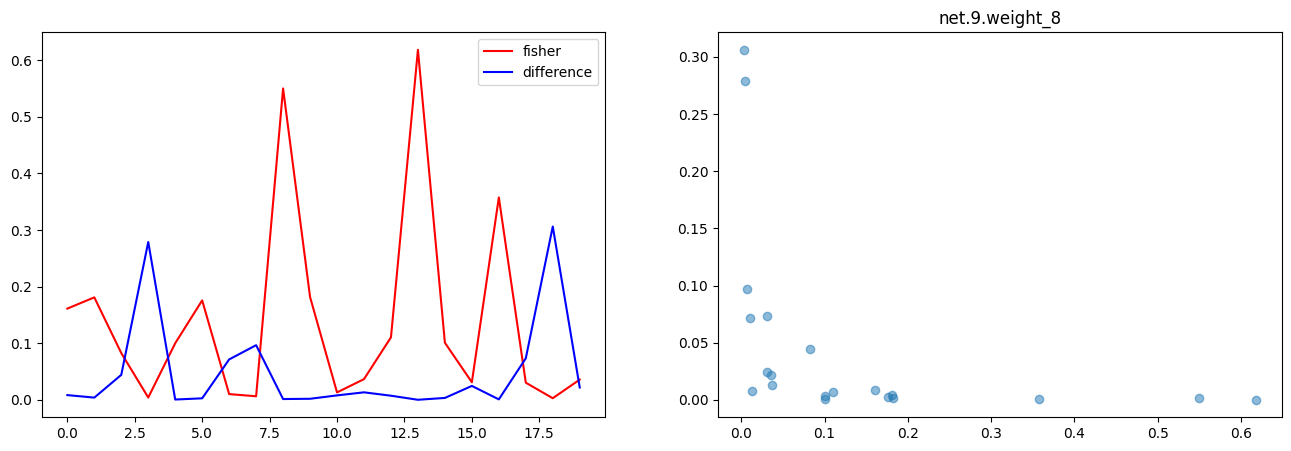

Max fisher is 0.56828 and it's parameter diff is 0.00082
Min Parameter diff is 0.44953 and it's fisher is 0.00656
fisher > parameter diff: 16
fisher <= parameter diff: 4


<Figure size 640x480 with 0 Axes>

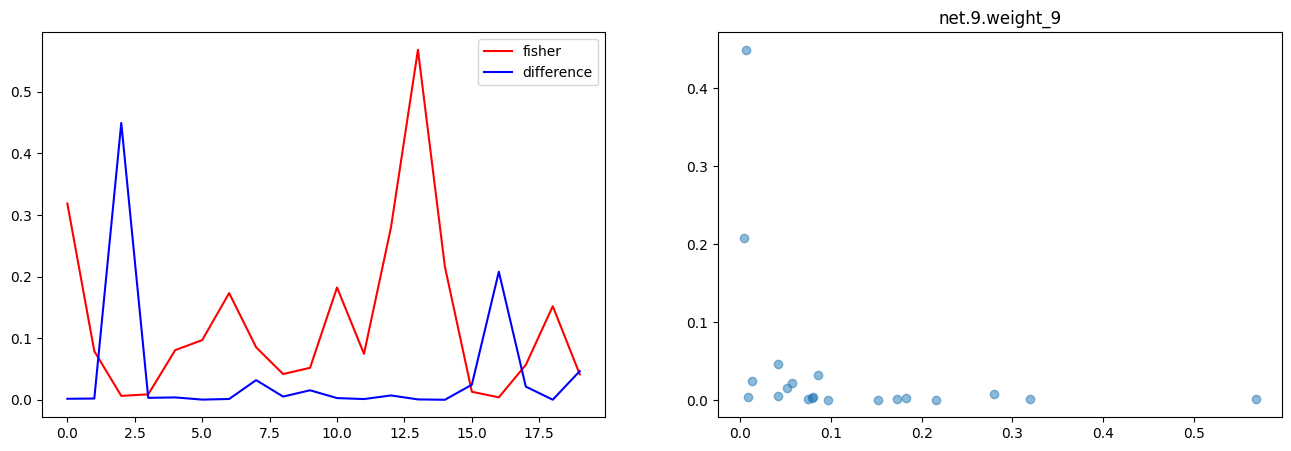


net.9.bias
torch.Size([10])
Max fisher is 0.11143 and it's parameter diff is 0.00418
Min Parameter diff is 0.20379 and it's fisher is 0.00130
fisher > parameter diff: 7
fisher <= parameter diff: 3


<Figure size 640x480 with 0 Axes>

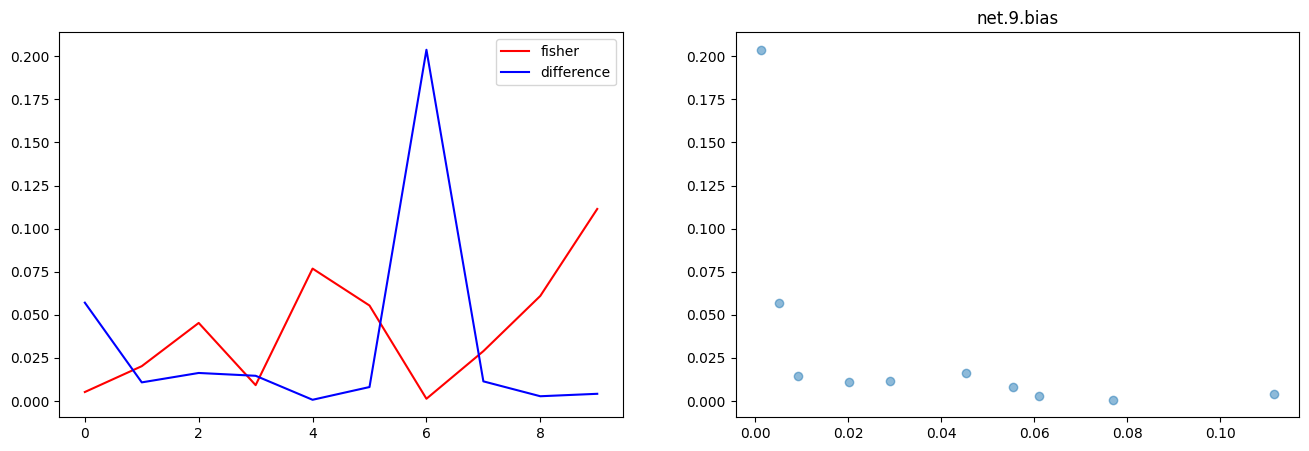

In [53]:
def plot(fisher_matrix, optim_para, param, name):
  plt.cla(); plt.clf()
  #print(fisher_matrix.shape, optim_para.shape, param.shape)
  fisher = fisher_matrix.cpu().detach()
  optim = optim_para.cpu().detach()
  param = param.cpu().detach()

  fisher_max = np.argmax(fisher)
  param_diff_max = np.argmax((optim - param).abs())
  print(f'Max fisher is {fisher[fisher_max]:.5f} and it\'s parameter diff is {(optim - param).abs()[fisher_max]:.5f}')
  print(f'Min Parameter diff is {(optim - param).abs()[param_diff_max]:.5f} and it\'s fisher is {fisher[param_diff_max]:.5f}')
  # compare
  print('fisher > parameter diff: {}'.format((fisher > (optim - param).abs()).sum()))
  print('fisher <= parameter diff: {}'.format((fisher <= (optim - param).abs()).sum()))

  # plot
  fig, ax = plt.subplots(1, 2, figsize=(16, 5)) # row, col
  ax[0].plot(fisher.reshape(-1), 'r', label='fisher')
  ax[0].plot((optim - param).abs().reshape(-1), 'b', label='difference')
  ax[0].legend()

  ax[1].scatter(fisher, (optim - param).abs().reshape(-1), alpha=0.5)
  plt.title(name)
  plt.show()

# test
idx = 0
for name, param in model.named_parameters():

  # Name
  print(name)
  print(param.detach().shape)

  if len(param.detach().shape) != 1:
    for i in range(param.detach().shape[0]):
      plot(fisher_matrix[0][name][i].flatten(), optim_para[0][name][i].flatten(), param[i].flatten(), f'{name}_{i}')
  else:
    plot(fisher_matrix[0][name], optim_para[0][name], param, name)
  # END
  idx += 1
  print()

In [54]:
import datetime
import pytz

now = datetime.datetime.now(pytz.timezone('Asia/Taipei')).strftime("%Y-%m-%d_%H_%M_%S")
print(now)

2025-03-25_21_34_11
